In [1]:
!pip install opendatasets --quiet
import opendatasets as od
od.download("https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000")


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: Satyajeet69
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000


100%|██████████| 5.20G/5.20G [01:42<00:00, 54.7MB/s]


In [7]:
!pip install timm --quiet

import os
import torch
import timm
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from tqdm import tqdm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 67.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 59.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 41.4 MB/s eta 0:00:00


In [49]:

from PIL import Image
from torch.utils.data import Dataset
from sklearn.preprocessing import LabelEncoder



In [2]:
import os
import shutil

# Paths
src1 = "/content/skin-cancer-mnist-ham10000/HAM10000_images_part_1"
src2 = "/content/skin-cancer-mnist-ham10000/HAM10000_images_part_2"
dst = "/content/all_images"

os.makedirs(dst, exist_ok=True)


for folder in [src1, src2]:
    for file in os.listdir(folder):
        shutil.copy(os.path.join(folder, file), dst)


In [3]:
import pandas as pd


meta_path = "/content/skin-cancer-mnist-ham10000/HAM10000_metadata.csv"
df = pd.read_csv(meta_path)


print("Disease Classes:", df['dx'].unique())


Disease Classes: ['bkl' 'nv' 'df' 'mel' 'vasc' 'bcc' 'akiec']


In [63]:
label_map = {
    'nv': 'Melanocytic_nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign_keratosis',
    'bcc': 'Basal_cell_carcinoma',
    'akiec': 'Actinic_keratoses',
    'vasc': 'Vascular_lesions',
    'df': 'Dermatofibroma'
}

df['label'] = df['dx'].map(label_map)


In [64]:
from sklearn.model_selection import train_test_split


train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.1, stratify=train_df['label'], random_state=42)
class SkinDataset(Dataset):
    def __init__(self, dataframe, image_dir, transform=None):
        self.dataframe = dataframe.reset_index(drop=True)
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = self.dataframe.loc[idx, 'image_id'] + ".jpg"
        label = self.dataframe.loc[idx, 'label']
        img_path = os.path.join(self.image_dir, img_name)

        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        return image, label


In [65]:
def save_images(df_split, split_name):
    for _, row in df_split.iterrows():
        img_id = row['image_id']
        label = row['label']
        src_path = os.path.join(dst, f"{img_id}.jpg")
        dest_dir = os.path.join("data", split_name, label)
        os.makedirs(dest_dir, exist_ok=True)
        shutil.copy(src_path, os.path.join(dest_dir, f"{img_id}.jpg"))

save_images(train_df, "train")
save_images(val_df, "val")
save_images(test_df, "test")


In [86]:
from torch.utils.data import DataLoader
from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])
data_dir = "/content/data"
train_dataset = SkinDataset(train_df, "/content/all_images", train_transforms)
val_dataset = SkinDataset(val_df, "/content/all_images", val_transforms)
test_dataset = SkinDataset(test_df, "/content/all_images", val_transforms)

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_dataset.dataframe['label'] = le.fit_transform(train_dataset.dataframe['label'])
val_dataset.dataframe['label'] = le.transform(val_dataset.dataframe['label'])
test_dataset.dataframe['label'] = le.transform(test_dataset.dataframe['label'])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

class_names = le.classes_


In [80]:
from collections import Counter
from torchvision import datasets
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def get_class_weights(dataset_path):
    dataset = datasets.ImageFolder(dataset_path)
    class_counts = Counter([label for _, label in dataset.samples])
    total_samples = sum(class_counts.values())

    weights = []
    for i in range(len(dataset.classes)):
        class_count = class_counts[i]
        weights.append(total_samples / (len(dataset.classes) * class_count))

    return torch.tensor(weights, dtype=torch.float)


train_dir = '/content/data/train'
class_weights = get_class_weights(train_dir).to(device)

In [81]:
# Number of classes


# Load Vision Transformer
model = timm.create_model("vit_tiny_patch16_224", pretrained=True, num_classes=7) #num_classes=7 from length of Disease Classes
model = model.to("cuda" if torch.cuda.is_available() else "cpu")


In [82]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4,weight_decay = 0.01)
print(device, criterion, optimizer)

cuda CrossEntropyLoss() Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0.01
)


In [83]:
def train(model, train_loader, val_loader, criterion, optimizer, epochs=5):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch {epoch+1}, Training loss: {running_loss/len(train_loader):.4f}")

        # Validation accuracy
        model.eval()
        correct = total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
        print(f"Validation Accuracy: {100 * correct / total:.2f}%\n")
        model.train()


In [84]:
train(model, train_loader, val_loader, criterion, optimizer, epochs=5)


Epoch 1/5: 100%|██████████| 226/226 [01:42<00:00,  2.21it/s]


Epoch 1, Training loss: 1.2431
Validation Accuracy: 69.70%



Epoch 2/5: 100%|██████████| 226/226 [01:40<00:00,  2.25it/s]


Epoch 2, Training loss: 0.8671
Validation Accuracy: 58.35%



Epoch 3/5: 100%|██████████| 226/226 [01:38<00:00,  2.30it/s]


Epoch 3, Training loss: 0.7490
Validation Accuracy: 68.33%



Epoch 4/5: 100%|██████████| 226/226 [01:39<00:00,  2.27it/s]


Epoch 4, Training loss: 0.6452
Validation Accuracy: 66.08%



Epoch 5/5: 100%|██████████| 226/226 [01:49<00:00,  2.06it/s]


Epoch 5, Training loss: 0.6341
Validation Accuracy: 71.45%



Classification Report:

                      precision    recall  f1-score   support

   Actinic_keratoses       0.31      0.77      0.45        65
Basal_cell_carcinoma       0.73      0.48      0.58       103
    Benign_keratosis       0.56      0.62      0.59       220
      Dermatofibroma       0.85      0.74      0.79        23
    Melanocytic_nevi       0.97      0.72      0.82      1341
            Melanoma       0.35      0.78      0.48       223
    Vascular_lesions       0.81      0.93      0.87        28

            accuracy                           0.70      2003
           macro avg       0.66      0.72      0.65      2003
        weighted avg       0.82      0.70      0.74      2003



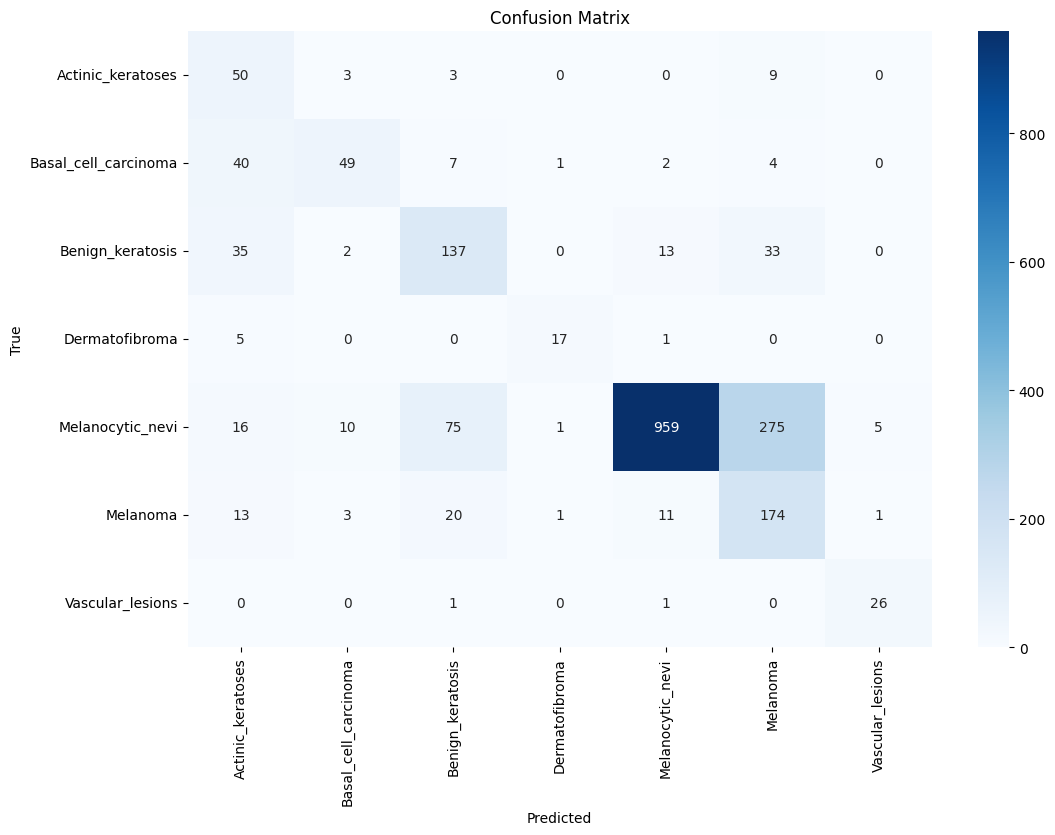

In [89]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


model.eval()


all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print("Classification Report:\n")
print(classification_report(all_labels, all_preds, target_names=class_names))


cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


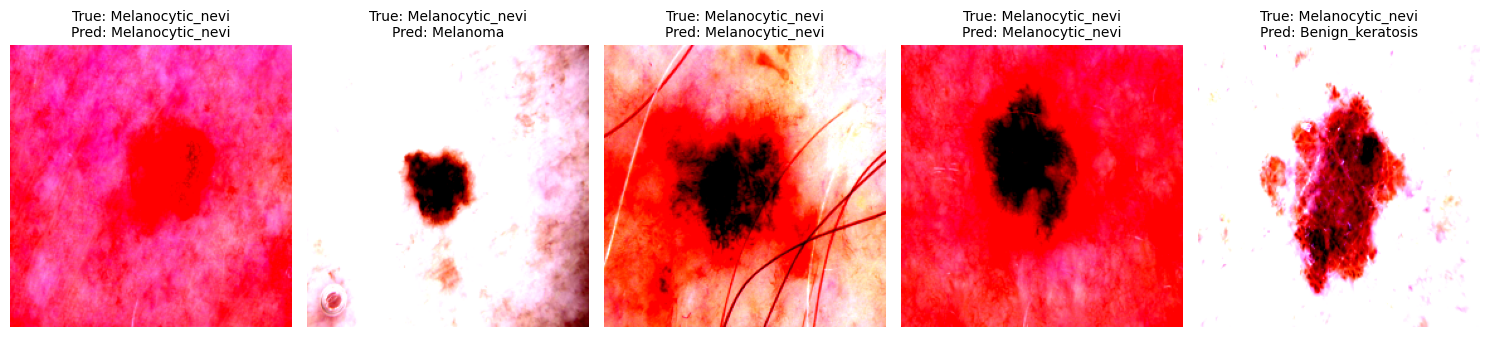

In [91]:
import random

def show_random_predictions(model, dataset, class_names, num_images=5):
    model.eval()
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

    for ax in axes:
        idx = random.randint(0, len(dataset) - 1)
        image, label = dataset[idx]
        image_tensor = image.unsqueeze(0).to(device)

        with torch.no_grad():
            output = model(image_tensor)
            _, pred = torch.max(output, 1)

        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        ax.axis('off')
        ax.set_title(f"True: {class_names[label]}\nPred: {class_names[pred.item()]}", fontsize=10)

    plt.tight_layout()
    plt.show()


show_random_predictions(model, test_dataset, class_names, num_images=5)


In [92]:
from PIL import Image

def predict_image(image_path, model, transform, label_encoder):
    model.eval()
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(image)
        _, preds = torch.max(outputs, 1)
    return label_encoder.inverse_transform([preds.cpu().item()])[0]


In [94]:
predict_image("/content/all_images/ISIC_0030173.jpg", model, val_transforms, le)


'Melanoma'

In [95]:
torch.save(model.state_dict(), "vit_skin_disease.pth")


In [97]:
from google.colab import files
files.download("vit_skin_disease.pth")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>